In [9]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle
import os

style.use('ggplot')

%matplotlib inline

In [10]:
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [11]:
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

In [12]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
if not os.path.exists('linearregressionmodel.pickle'):
    print('running model')
    model = LinearRegression()
    model.fit(X_train, y_train)
    with open('linearregressionmodel.pickle', 'wb') as f:
        pickle.dump(model, f)
else: 
    print('grabbing pickled model')
    pickle_in = open('linearregressionmodel.pickle', 'rb')
    model = pickle.load(pickle_in)
accuracy = model.score(X_test, y_test)
accuracy

grabbing pickled model


0.97147748188980287

In [20]:
forecast_set = model.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 24*3600
next_unix = last_unix+one_day

In [21]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

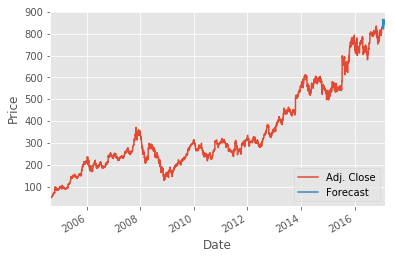

In [22]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()